In [1]:
import datetime as dt

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mdates

from IPython.display import Markdown, display, Math
import pandas as pd

import scipy.stats as sps

sns.set()

In [2]:
T = pd.read_csv(
    "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv",
    index_col=["Country/Region"]
).sort_index()

In [3]:
T.drop(['Province/State', "Lat", 'Long'], 1, inplace=True)

In [4]:
T = T.transpose()
T.index = pd.to_datetime(T.index, infer_datetime_format=True)

In [5]:
SI_sh_ISS = 1.87
SI_ra_ISS = 0.28

def gamma_mu_sd_from_shape_rate(shape, rate):
    mu = shape / rate
    sd = np.sqrt(shape) / rate
    return mu, sd

def overall_infectivity(incid, SI_y):
    T = incid.size
    _lambda = np.zeros(T)
    _lambda[0] = np.nan
    for t in range(T):
        if not t:
            continue
        _lambda[t] = np.sum(
            SI_y[:t+1] * 
            incid[:t+1][::-1]
        )
    return _lambda

def posterior_from_si_distr(incid, SI_y, a_prior, b_prior, t_start, t_end):
    nb_time_periods = t_start.size
    _lambda = overall_infectivity(incid, SI_y)
    final_mean_si = np.sum(
        SI_y * np.arange(0, SI_y.size, 1)
    )
    a_posterior = np.zeros(shape=nb_time_periods)
    b_posterior = np.zeros(shape=nb_time_periods)
    for t in range(nb_time_periods):
        incid_sum = np.sum(incid[t_start[t]:t_end[t]+1])
        lambda_sum = np.sum(_lambda[t_start[t]:t_end[t]+1])
        if t_end[t] > final_mean_si and incid_sum > 25:
            a_posterior[t] = a_prior + incid_sum
            b_posterior[t] = 1 / (1 / b_prior + lambda_sum)
        else:
            a_posterior[t] = .01
            b_posterior[t] = 1
    return a_posterior, b_posterior, lambda_sum

def epi_estim_Rt(df,
                 SI_mu=None, SI_sd=None,
                 SI_sh=None, SI_ra=None,
                 mu_prior=5, sd_prior=5,
                 CI=.99,
                 plot_incidence=False,
                 plot_Rt=True,
                 ax=None,
                 plot_SI=False,
                 plot_infectivity=False,
                 title='RESULTS',
                 window=14):
    
    cond1 = SI_mu is None and SI_sd is None
    cond2 = SI_sh is None and SI_ra is None
    
    if cond1 and cond2:
        raise Exception('Either SI_mu, SI_sd or SI_sh, SI_ra must be provided.')
    
    df = df.copy(deep=True)
    
    df.columns = ['incidence']
    incid = df.values.ravel()
    idx = df.index
    
    if plot_incidence:
        ax = df.plot(lw=1, color='k', alpha=.75, figsize=(12, 4))
        zero_incidence = df[df==0]
        if zero_incidence.size:
            ax.plot(zero_incidence, marker='o', ls='none', color='b', label='zero new cases')
        less_incidence = df[df<0]
        if less_incidence.size:
            ax.plot(less_incidence, marker='s', ls='none', color='r',label='less than zero')
        ax.legend()
        ax.set(
            title=f'{title} observed incidence'
        )
        plt.show()
    
    less_than_zero = incid < 0
    if less_than_zero.sum():
        print('WARNING: negative values in incidence. Forcing to NaN. Values will be imputed.')
        df.loc[df.incidence<0, 'incidence'] = np.nan
    
    nans = np.isnan(incid).sum()
    if nans:
        print('WARNING: NaN values in incidence. Imputing values with ffill method...')
        df.fillna(method='ffill', inplace=True)
        incid = df.values.ravel()
    
    # quantiles for confidence window
    q1 = (1 - CI) / 2
    q2 = 1 - q1
    
    if SI_mu is None:
        SI_mu, SI_sd = gamma_mu_sd_from_shape_rate(SI_sh, SI_ra)
    
    # calculate discretized serial window distribution
    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x_min = 0
    SI_x_max = int(SI_dist.ppf(.999))
    SI_mu = SI_dist.stats(moments='m')
    SI_x = np.linspace(SI_x_min, SI_x_max, SI_x_max+1)
    SI_y = SI_dist.pdf(SI_x)
    # pad SI with zeros
    SI_tot = np.concatenate((SI_y, np.zeros(incid.size - SI_y.size)))
    
    if plot_SI:
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.bar(SI_x, SI_y, alpha=.5)
        ax.axvline(SI_mu, color='r', ls='--')
        ax.set(
            title=f'{title} Serial Interval: $\mu={SI_mu:.1f}$, $\sigma={SI_sd:.1f}$, '+\
                  f'shape={SI_sh:.3f}, rate={SI_ra:.3f}'
        )
        plt.show()
    
    # calculate shape and scale Rt priors
    a_prior = (mu_prior / sd_prior) ** 2
    b_prior = (sd_prior ** 2) / mu_prior
    
    # length of all observations
    T = incid.size
    
    # start and end of posteriors
    t_start = np.arange(1, T - (window - 1), 1)
    t_end = t_start + (window - 1)
    
    # calculate a and b posteriors
    a_posterior, b_posterior, lambda_sum = posterior_from_si_distr(
        incid, SI_tot, a_prior, b_prior, t_start, t_end)

    # mean of Rt posteriors
    mean_posterior = a_posterior * b_posterior

    # standard deviation of Rt posteriors
    std_posterior = np.sqrt(a_posterior) * b_posterior

    # lower quantile of Rt posterior
    quantile_lo_posterior = sps.gamma.ppf(q1,
      a=a_posterior,
      scale=b_posterior
    )
    # higher quantile of Rt posterior
    quantile_hi_posterior = sps.gamma.ppf(q2,
      a=a_posterior,
      scale=b_posterior
    )
    
    res_index = idx[:-window]
    res = pd.DataFrame({
        'date': res_index,
        'R': mean_posterior,
        'std': std_posterior,
        f'q_{q1:.2%}': quantile_lo_posterior,
        f'q_{q2:.2%}': quantile_hi_posterior,
    })
    res.set_index('date', inplace=True)
    
    if plot_Rt:    
        res.plot(
            y='R', color='w', alpha=.1, lw=1, ylim=(0, 5),
            ax=ax
        )

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior<1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior<1, quantile_lo_posterior, 1), 
            alpha=1, color='C2', label='lower than 1')

        ax.fill_between(
            res.index, 
            np.where(quantile_hi_posterior>1, quantile_hi_posterior, 1), 
            np.where(quantile_lo_posterior>1, quantile_lo_posterior, 1), 
            alpha=1, color='C3', label='higher than 1')

        ax.set(
            title=f'{title}: Rt (C.I. {CI:.0%})',
            ylim=(0, 5),
            xlim=(idx[0], idx[-1]),
            ylabel='Rt'
        )
        ax.tick_params(axis='y', which='both', labelleft='on', labelright='on')
        #ax.legend(False)

        ax.axhline(1, color='k', ls='-', alpha=.5)
        #plt.show()
    
    return res

In [6]:
t_india = T['India']
if isinstance(t_india, pd.DataFrame):
    t_india = t_india.sum(axis=1)

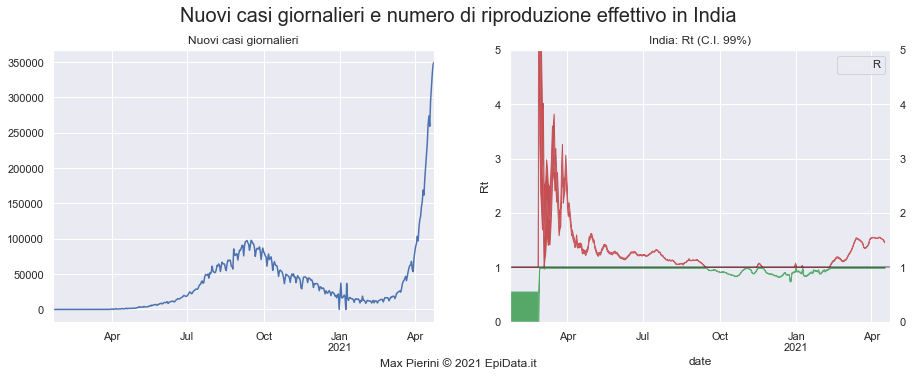

In [7]:
i_india = t_india.diff()
i_india[i_india<0] = 0

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
i_india.plot(ax=ax[0], title='Nuovi casi giornalieri')
R_india = epi_estim_Rt(i_india[1:],
                SI_sh=SI_sh_ISS,
                SI_ra=SI_ra_ISS,
                ax=ax[1],
                window=7,
                title='India')

fig.suptitle('Nuovi casi giornalieri e numero di riproduzione effettivo in India', fontsize=20, y=1)
fig.text(
   .5, 0, 'Max Pierini © 2021 EpiData.it',
    ha='center'
)
fig.set_facecolor('w'); plt.show();

In [8]:
Rt_india = R_india[(R_india.R>1)&(R_india.index>'2021-01-01')].R.values

In [9]:
t_italy = T['Italy']
if isinstance(t_italy, pd.DataFrame):
    t_italy = t_italy.sum(axis=1)

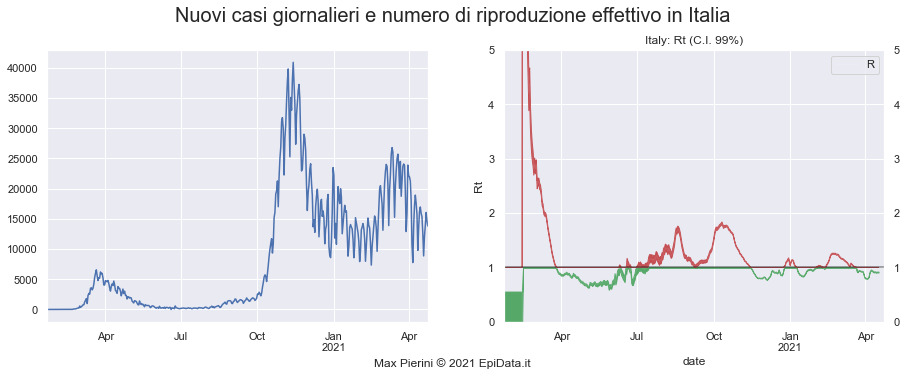

In [10]:
i_italy = t_italy.diff()
i_italy[i_italy<0] = 0

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
i_italy.plot(ax=ax[0])
R_italy = epi_estim_Rt(i_italy[1:],
                SI_sh=SI_sh_ISS,
                SI_ra=SI_ra_ISS,
                ax=ax[1],
                window=7,
                title='Italy')

fig.suptitle('Nuovi casi giornalieri e numero di riproduzione effettivo in Italia', fontsize=20, y=1)
fig.text(
   .5, 0, 'Max Pierini © 2021 EpiData.it',
    ha='center'
)
fig.set_facecolor('w'); plt.show();

In [11]:
base_incidence = i_italy[
    (i_italy.index>=R_italy.index[0])
    &
    (i_italy.index<=R_italy.index.max())
].values

In [12]:
base_R = R_italy.R.values

In [13]:
Rt = np.concatenate((base_R, Rt_india))

In [14]:
date_range = pd.date_range(
    start=R_italy.index[0],
    end=R_italy.index[0] + pd.Timedelta(days=Rt.size+7-1)
)

In [15]:
def window_Rt(Ay, By, w):
    x = np.arange(0, w)
    a = (By - Ay) / w
    b = Ay
    y = a * x + b
    return y

In [16]:
def SI_incidence(dt, base_incidence, base_Rt, simu_Rt, SI_sh, SI_ra, population, w=7):
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    
    pdays = base_incidence.size
    
    w_Rt = window_Rt(base_Rt[-1], simu_Rt[0], w)
    Rt = np.concatenate((base_Rt, w_Rt, simu_Rt))
    tdays = Rt.size
    
    days = np.arange(0, tdays)

    y = np.zeros(shape=(tdays))
    y[:pdays] = base_incidence

    SI_dist = sps.gamma(a=SI_sh, scale=1/SI_ra)
    SI_x = np.arange(0, tdays, 1)
    SI_y = SI_dist.pdf(SI_x)
    SI_y /= SI_y.sum()
    SI_mu = SI_dist.mean()
    SI_sd = SI_dist.std()
    
    #print(y.size, Rt)

    np.random.seed(1976)
    for day in days[pdays:]:
        for i in range(1, day+1):
            y[day] += y[day-i] * SI_y[i] * Rt[day-i]

    y[y<1] = 1
    Y = y / population * 1e5

    ax[0].plot(dt[:pdays], Y[:pdays], lw=5, label='incidenza osservata in Italia')
    ax[0].plot(dt[pdays:pdays+w], Y[pdays:pdays+w], lw=2, label='incidenza di passaggio')
    ax[0].plot(dt[pdays+w:], Y[pdays+w:], lw=4, label='incidenza simulata in Italia')
    ax[0].legend()
    ax[0].set(
        title=f'Incidenza simulata',
        ylabel='su 100,000 abitanti'
    )
    ax1 = ax[0].twinx()
    ax1.plot(dt, y, alpha=0)
    ax1.grid(alpha=0)
    ax1.set(ylabel='incidenza effettiva')
    
    ax[1].plot(dt[:pdays], Rt[:pdays], lw=5, label='Rt osservato in Italia')
    ax[1].plot(dt[pdays:pdays+w], Rt[pdays:pdays+w], lw=3, label='Rt di passaggio')
    ax[1].plot(dt[pdays+w:], Rt[pdays+w:], lw=4, label='Rt osservato in India da Febbraio 2021')
    ax[1].axhline(1, color='r', ls='--')
    ax[1].set(ylim=(0, 4))
    ax[1].legend()
    
    ax[0].annotate(
        f"{Y[-1]:.0f} su 100k\n"
        f"{y[-1]:,.0f} giornalieri\n".replace(',', "`")+
        f"al {dt[-1].date()}",
        xy=(dt[-1], Y[-1]),
        xytext=(dt[dt.size//2], 300),
        arrowprops=dict(color='k')
    )
    
    fig.text(
       .5, .48, 'Max Pierini © 2021 EpiData.it',
        ha='center'
    )
    
    plt.show()

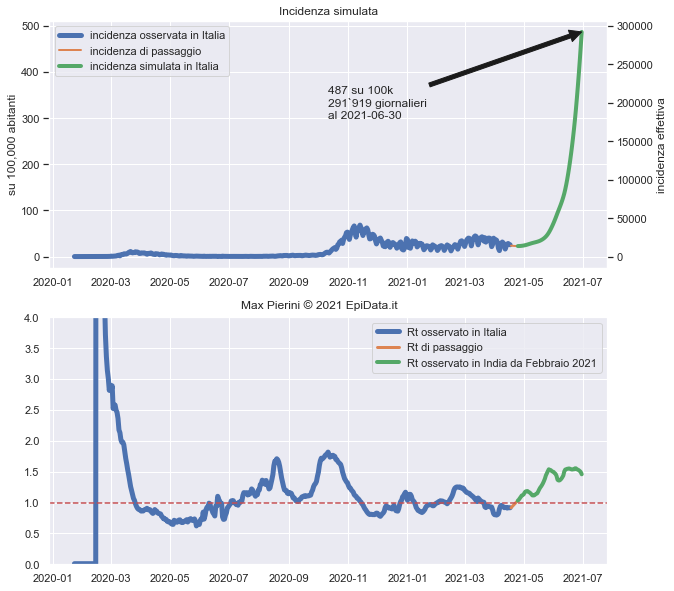

In [17]:
SI_incidence(
    date_range, base_incidence, base_R, Rt_india, SI_sh_ISS, SI_ra_ISS,
    population=6e7
)

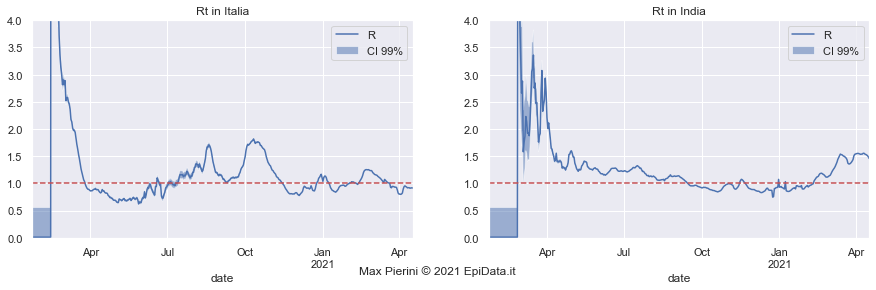

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
R_italy.plot(ax=ax[0], y='R', title='Rt in Italia')
ax[0].fill_between(
    R_italy.index,
    R_italy['q_0.50%'], R_italy['q_99.50%'],
    alpha=.5, label='CI 99%'
)
R_india.plot(ax=ax[1], y='R', title='Rt in India')
ax[1].fill_between(
    R_india.index,
    R_india['q_0.50%'], R_india['q_99.50%'],
    alpha=.5, label='CI 99%'
)
for axes in ax:
    axes.set(
        ylim=(0, 4)
    )
    axes.axhline(1, color='r', ls='--')
    axes.legend(loc='upper right')
    
fig.text(
   .5, 0, 'Max Pierini © 2021 EpiData.it',
    ha='center'
)
plt.show()

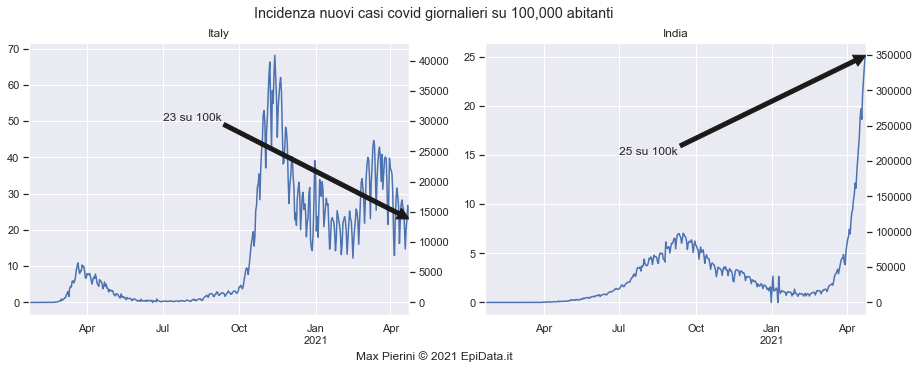

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), )

(i_italy/60000000*100000).plot(ax=ax[0], title='Italy')
ax01 = ax[0].twinx()
(i_italy).plot(ax=ax01, alpha=0)
ax01.grid(alpha=0)

(i_india/1390885000*100000).plot(ax=ax[1], title='India')
ax11 = ax[1].twinx()
(i_india).plot(ax=ax11, alpha=0)
ax11.grid(alpha=0)

last_i_italy = i_italy[-1]/60000000*100000
ax[0].annotate(
    f"{last_i_italy:.0f} su 100k",
    xy=(i_italy.index[-1], last_i_italy),
    xytext=('2020-07-01', 50),
    arrowprops=dict(color='k')
)

last_i_india = i_india[-1]/1390885000*100000
ax[1].annotate(
    f"{last_i_india:.0f} su 100k",
    xy=(i_india.index[-1], last_i_india),
    xytext=('2020-07-01', 15),
    arrowprops=dict(color='k')
)

fig.suptitle('Incidenza nuovi casi covid giornalieri su 100,000 abitanti')

fig.text(
   .5, 0, 'Max Pierini © 2021 EpiData.it',
    ha='center'
)
plt.show()